In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('..')

from models.estimators._common import get_default_params

In [113]:
def get_condition(params, defaults, name):
    if name == 'l1':
        cond = (params['alpha'] == defaults['alpha']) & (params['max_iter'] == defaults['max_iter'])
    elif name == 'l2':
        cond = (params['alpha'] == defaults['alpha']) & (params['max_iter'] == defaults['max_iter'])
    elif name == 'dt':
        cond = (params['max_depth'] == defaults['max_depth']) & (params['min_samples_leaf'] == defaults['min_samples_leaf'])
    elif name == 'rf':
        cond = (params['max_depth'] == defaults['max_depth']) & (params['min_samples_leaf'] == defaults['min_samples_leaf'])
    elif name == 'et':
        cond = (params['max_depth'] == defaults['max_depth']) & (params['min_samples_leaf'] == defaults['min_samples_leaf'])
    elif name == 'kr':
        cond = (params['alpha'] == defaults['alpha']) & (params['gamma'] == defaults['gamma']) & (params['kernel'] == defaults['kernel']) & (params['degree'] == defaults['degree'])
    elif name == 'cb':
        cond = (params['depth'] == defaults['depth']) & (params['l2_leaf_reg'] == defaults['l2_leaf_reg'])
    elif name == 'lgbm':
        cond = (params['max_depth'] == defaults['max_depth']) & (params['reg_lambda'] == defaults['reg_lambda'])
    elif name == 'cf':
        cond = (params['max_depth'] == defaults['max_depth']) & (params['min_samples_leaf'] == defaults['min_samples_leaf'])
    else:
        raise ValueError("Unrecognised 'get_condition' key.")
    
    return cond

In [112]:
def get_base_id(est, bl, ds, defaults, file_prefix):
    model_name = f'{est}_{bl}'
    params = pd.read_csv(f'../results/predictions/{ds}/{model_name}/{file_prefix}_params.csv')
    cond = get_condition(params, defaults, bl)
    return int(params.loc[cond, 'id'])

In [184]:
def get_default_id(est, bl, ds):
    defaults = get_default_params(bl)
    model_name = f'{est}_{bl}'

    if est in ['sl', 'ipsws', 'dmls', 'drs', 'xl']:
        id = get_base_id(est, bl, ds, defaults, model_name)
    elif est == 'tl':
        m0_id = get_base_id(est, bl, ds, defaults, f'{model_name}_m0')
        m1_id = get_base_id(est, bl, ds, defaults, f'{model_name}_m1')
        params = pd.read_csv(f'../results/predictions/{ds}/{model_name}/{model_name}_cate_params.csv')
        id = int(params.loc[(params['m0'] == m0_id) & (params['m1'] == m1_id), 'id'])
    elif est == 'cf':
        params = pd.read_csv(f'../results/predictions/{ds}/{est}/{est}_params.csv')
        cond = get_condition(params, defaults, est)
        id = int(params.loc[cond, 'id'])
    else:
        id = -1
    
    return id

In [109]:
def get_def_perf(est, bl, ds, test, targets):
    def_id = get_default_id(est, bl, ds)
    results = test.apply(lambda x: x.loc[x['param_id'] == def_id, targets])
    return [np.mean(results[target]) for target in targets]

In [85]:
def get_best_metric(df, target):
    res = df.apply(lambda x: x.loc[x[target].idxmin(), [target]])
    return np.mean(res[target])

In [60]:
def get_oracle_perf(test, targets):
    return [get_best_metric(test, target) for target in targets]

In [185]:
def plot_def_vs_oracle(ds, targets, estmators, base_learners):
    def_perfs = []
    oracle_perfs = []
    for est in estmators:
        if est == 'cf':
            df_test = pd.read_csv(f'../results/metrics/{ds}/{est}/{est}_test_metrics.csv')
            iter_gr = df_test.groupby(['iter_id'], as_index=False)

            def_perf = get_def_perf(est, est, ds, iter_gr, targets)
            oracle_perf = get_oracle_perf(iter_gr, targets)
            def_perfs.append(def_perf)
            oracle_perfs.append(oracle_perf)
        else:
            for bl in base_learners:
                model_name = f'{est}_{bl}'

                try:
                    df_test = pd.read_csv(f'../results/metrics/{ds}/{model_name}/{model_name}_test_metrics.csv')
                    iter_gr = df_test.groupby(['iter_id'], as_index=False)
                except:
                    continue

                def_perf = get_def_perf(est, bl, ds, iter_gr, targets)
                oracle_perf = get_oracle_perf(iter_gr, targets)
                def_perfs.append(def_perf)
                oracle_perfs.append(oracle_perf)

    def_arr = np.array(def_perfs)
    oracle_arr = np.array(oracle_perfs)

    plt.scatter(def_arr[:, 0], def_arr[:, 1], label='default')
    plt.scatter(oracle_arr[:, 0], oracle_arr[:, 1], label='oracle')
    plt.xlabel(targets[0])
    plt.ylabel(targets[1])

In [186]:
def ax_def_vs_oracle(ds, targets, estmators, base_learners, ax):
    def_perfs = []
    oracle_perfs = []
    for est in estmators:
        if est == 'cf':
            df_test = pd.read_csv(f'../results/metrics/{ds}/{est}/{est}_test_metrics.csv')
            iter_gr = df_test.groupby(['iter_id'], as_index=False)

            def_perf = get_def_perf(est, est, ds, iter_gr, targets)
            oracle_perf = get_oracle_perf(iter_gr, targets)
            def_perfs.append(def_perf)
            oracle_perfs.append(oracle_perf)
        else:
            for bl in base_learners:
                model_name = f'{est}_{bl}'

                try:
                    df_test = pd.read_csv(f'../results/metrics/{ds}/{model_name}/{model_name}_test_metrics.csv')
                    iter_gr = df_test.groupby(['iter_id'], as_index=False)
                except:
                    continue

                def_perf = get_def_perf(est, bl, ds, iter_gr, targets)
                oracle_perf = get_oracle_perf(iter_gr, targets)
                def_perfs.append(def_perf)
                oracle_perfs.append(oracle_perf)

    def_arr = np.array(def_perfs)
    oracle_arr = np.array(oracle_perfs)

    ax.scatter(def_arr[:, 0], def_arr[:, 1], label='default', edgecolors='black', linewidths=0.5)
    ax.scatter(oracle_arr[:, 0], oracle_arr[:, 1], label='oracle', edgecolors='black', linewidths=0.5)
    #ax.set_xlabel(targets[0])
    #ax.set_ylabel(targets[1])

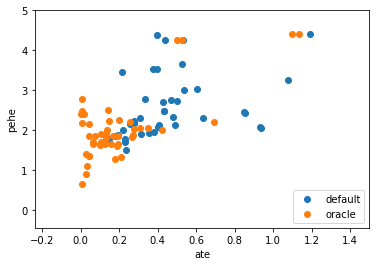

In [141]:
ds = 'ihdp'
targets = ['ate', 'pehe']

estmators = ['sl', 'tl', 'ipsws', 'dmls', 'drs', 'xl']
base_learners = ['l1', 'l2', 'dt', 'rf', 'et', 'kr', 'lgbm', 'cb']

plot_def_vs_oracle(ds, targets, estmators, base_learners)
plt.xlim(right=1.5)
plt.ylim(top=5)
plt.legend(loc='lower right')

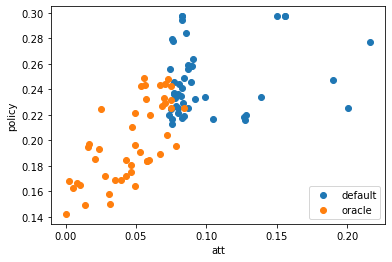

In [143]:
ds = 'jobs'
targets = ['att', 'policy']

estmators = ['sl', 'tl', 'ipsws', 'dmls', 'drs', 'xl']
base_learners = ['l1', 'l2', 'dt', 'rf', 'et', 'kr', 'lgbm', 'cb']

plot_def_vs_oracle(ds, targets, estmators, base_learners)
#plt.xlim(right=1.5)
#plt.ylim(top=5)
plt.legend(loc='lower right')

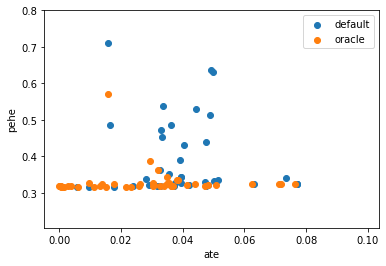

In [151]:
ds = 'twins'
targets = ['ate', 'pehe']

estmators = ['sl', 'tl', 'ipsws', 'dmls', 'drs', 'xl']
base_learners = ['l1', 'l2', 'dt', 'rf', 'et', 'kr', 'lgbm', 'cb']

plot_def_vs_oracle(ds, targets, estmators, base_learners)
#plt.xlim(right=1.5)
plt.ylim(top=0.8)
plt.legend()

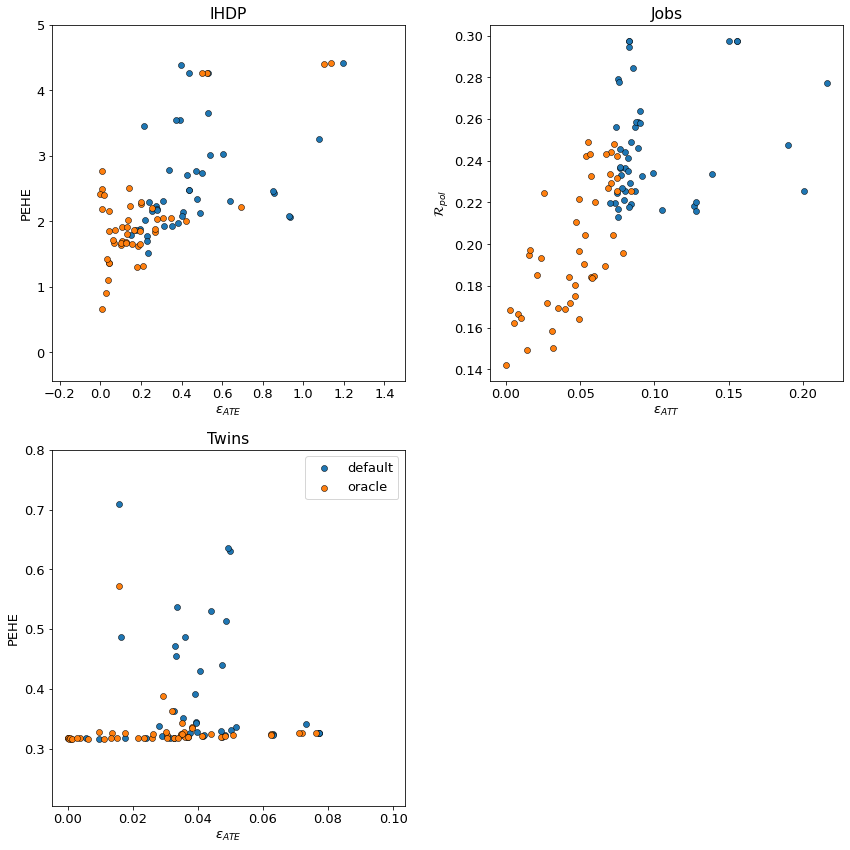

In [187]:
estmators = ['sl', 'tl', 'ipsws', 'dmls', 'drs', 'xl', 'cf']
base_learners = ['l1', 'l2', 'dt', 'rf', 'et', 'kr', 'lgbm', 'cb']

plt.rcParams.update({'font.size': 13})
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

ax = axs[0][0]
ds = 'ihdp'
targets = ['ate', 'pehe']

ax_def_vs_oracle(ds, targets, estmators, base_learners, ax)
ax.set_title('IHDP')
ax.set_xlim(right=1.5)
ax.set_ylim(top=5)
ax.set_xlabel('$\epsilon_{ATE}$')
ax.set_ylabel('PEHE')
#ax.grid('on')

ax = axs[0][1]
ds = 'jobs'
targets = ['att', 'policy']

ax_def_vs_oracle(ds, targets, estmators, base_learners, ax)
ax.set_title('Jobs')
#plt.xlim(right=1.5)
#plt.ylim(top=5)
ax.set_xlabel('$\epsilon_{ATT}$')
ax.set_ylabel('$\mathcal{R}_{pol}$')

ax = axs[1][0]
ds = 'twins'
targets = ['ate', 'pehe']

ax_def_vs_oracle(ds, targets, estmators, base_learners, ax)
ax.set_title('Twins')
#plt.xlim(right=1.5)
ax.set_ylim(top=0.8)
ax.set_xlabel('$\epsilon_{ATE}$')
ax.set_ylabel('PEHE')

ax.legend()

#plt.legend()

ax = axs[1][1]
ax.axis('off')



plt.tight_layout()
plt.savefig('default_vs_oracle.pdf', dpi=1000)